In [43]:
import requests
import json
import pandas as pd
import os
import re
import time
from tqdm import tqdm
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import seaborn as sns
from matplotlib.lines import Line2D
import scipy.stats as stats

In [1]:
# === Funzione di calcolo Heaps' Law ===
def compute_heaps_params(team_df):
    """Calcola i parametri K e β della legge di Heaps per un DataFrame di squadra."""
    all_tokens = list(team_df["words"])
    total_words, unique_words, seen = [], [], set()

    for i, token in enumerate(all_tokens, start=1):
        seen.add(token)
        total_words.append(i)
        unique_words.append(len(seen))

    total_words = np.array(total_words)
    unique_words = np.array(unique_words)

    # Evita fit instabili su pochi punti
    if len(total_words) < 5 or len(np.unique(unique_words)) < 2:
        return None, None

    logN = np.log(total_words)
    logV = np.log(unique_words)

    coeffs = np.polyfit(logN, logV, 1)
    beta, logK = coeffs[0], coeffs[1]
    K = np.exp(logK)
    return K, beta

## Serie A

In [13]:
INPUT_DIR = "Serie_A_24_25_texts"

In [14]:
teams = set()

for csv_path in glob(os.path.join(INPUT_DIR, "*.csv")):
    try:
        df = pd.read_csv(csv_path, usecols=["team_name"])
        teams.update(df["team_name"].dropna().unique())
    except Exception as e:
        print(f"⚠️  Error reading {os.path.basename(csv_path)}: {e}")

unique_teams = sorted(teams)
print(f"✅ Found {len(unique_teams)} unique teams:\n")
for t in unique_teams:
    print("-", t)

✅ Found 20 unique teams:

- AC Milan
- AS Roma
- Atalanta
- Bologna
- Cagliari
- Como
- Empoli
- Fiorentina
- Genoa
- Hellas Verona
- Inter Milan
- Juventus
- Lazio
- Lecce
- Monza
- Napoli
- Parma Calcio 1913
- Torino
- Udinese
- Venezia


In [15]:
# === Loop su tutti i CSV ===
results = []
csv_files = glob(os.path.join(INPUT_DIR, "*.csv"))

for csv_path in tqdm(csv_files, desc="🔹 Calcolo Heaps' Law per ogni match", ncols=100):
    try:
        df = pd.read_csv(csv_path)
        if df.empty or "words" not in df.columns:
            continue

        team = df.iloc[0]["team_name"]
        match_id = df.iloc[0]["match_id"]

        K, beta = compute_heaps_params(df)
        if K is not None and beta is not None:
            results.append({
                "team_name": team,
                "match_id": match_id,
                "K": K,
                "beta": beta
            })
    except Exception as e:
        tqdm.write(f"❌ Errore su {os.path.basename(csv_path)}: {e}")

🔹 Calcolo Heaps' Law per ogni match: 100%|██████████████████████| 760/760 [00:06<00:00, 121.75it/s]


In [16]:
heaps_df_Serie_A_24_25 = pd.DataFrame(results)
heaps_df_Serie_A_24_25.head()

,team_name,match_id,K,beta
0,AC Milan,3944962,0.944779,0.857097
1,AC Milan,3944972,1.133882,0.814787
2,AC Milan,3944982,1.013976,0.811685
3,AC Milan,3944993,0.962190,0.833940
4,AC Milan,3945004,1.387095,0.767688


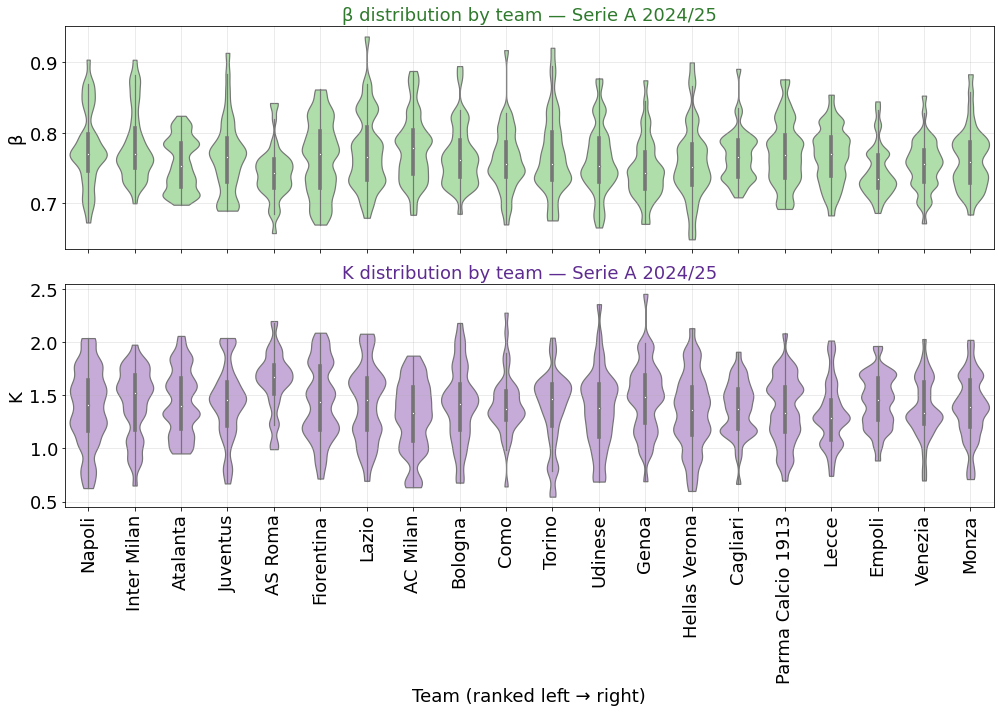

In [17]:
# --- Final 2024/25 Serie A ranking (matching your CSV names) ---
ranking = [
    "Napoli", 
    "Inter Milan", 
    "Atalanta", 
    "Juventus",
    "AS Roma", 
    "Fiorentina", 
    "Lazio",
    "AC Milan", 
    "Bologna", 
    "Como", 
    "Torino", 
    "Udinese", 
    "Genoa", 
    "Hellas Verona",
    "Cagliari", 
    "Parma Calcio 1913", 
    "Lecce", 
    "Empoli", 
    "Venezia", 
    "Monza",
]

# --- Clean names ---
df = heaps_df_Serie_A_24_25.copy()
df["team_name"] = (
    df["team_name"].astype(str)
    .str.replace(r"[\u200b-\u200d\uFEFF]", "", regex=True)
    .str.replace(r"\xa0", " ", regex=False)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# --- Filter valid data ---
df = df[df["team_name"].isin(ranking)].copy()
df_beta = df[np.isfinite(df["beta"])].dropna(subset=["beta"]).copy()
df_K = df[np.isfinite(df["K"])].dropna(subset=["K"]).copy()

for d in (df_beta, df_K):
    d["team_name"] = pd.Categorical(d["team_name"], categories=ranking, ordered=True)

# --- Colors ---
green_fill, green_edge = "#A8E6A3", "#2F7A2D"   # light + dark green
violet_fill, violet_edge = "#C8A2E0", "#5E2C91" # light + dark violet

# --- Plot (2×1 layout) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- β distribution (green) ---
sns.violinplot(
    data=df_beta, x="team_name", y="beta", order=ranking,
    ax=axes[0],
    inner="box",  # mostra la mediana e il box interno
    linewidth=1.2,
    cut=0,
    bw=0.2,
    scale="width",
    color=green_fill,
)
axes[0].set_title("β distribution by team — Serie A 2024/25", fontsize=18, color=green_edge)
axes[0].set_ylabel("β", fontsize=18)
axes[0].grid(True, alpha=0.3)

# 🔹 Remove team names on the first plot
axes[0].set_xlabel("")
axes[0].set_xticklabels([])

# --- K distribution (violet) ---
sns.violinplot(
    data=df_K, x="team_name", y="K", order=ranking,
    ax=axes[1],
    inner="box",
    linewidth=1.2,
    cut=0,
    bw=0.2,
    scale="width",
    color=violet_fill,
)
axes[1].set_title("K distribution by team — Serie A 2024/25", fontsize=18, color=violet_edge)
axes[1].set_ylabel("K", fontsize=18)
axes[1].set_xlabel("Team (ranked left → right)", fontsize=18)
axes[1].grid(True, alpha=0.3)

# 🔹 Larger tick labels for both axes
axes[0].tick_params(axis="y", labelsize=18)
axes[1].tick_params(axis="x", labelsize=18, rotation=90)
axes[1].tick_params(axis="y", labelsize=18)

plt.tight_layout()
plt.show()

## La Liga

In [46]:
INPUT_DIR = "Bundesliga_24_25_texts"

In [47]:
teams = set()

for csv_path in glob(os.path.join(INPUT_DIR, "*.csv")):
    try:
        df = pd.read_csv(csv_path, usecols=["team_name"])
        teams.update(df["team_name"].dropna().unique())
    except Exception as e:
        print(f"⚠️  Error reading {os.path.basename(csv_path)}: {e}")

unique_teams = sorted(teams)
print(f"✅ Found {len(unique_teams)} unique teams:\n")
for t in unique_teams:
    print("-", t)

✅ Found 18 unique teams:

- Augsburg
- Bayer Leverkusen
- Bayern Munich
- Bochum
- Borussia Dortmund
- Borussia Mönchengladbach
- Eintracht Frankfurt
- FC Heidenheim
- FSV Mainz 05
- Freiburg
- Hoffenheim
- Holstein Kiel
- RB Leipzig
- St. Pauli
- Union Berlin
- VfB Stuttgart
- Werder Bremen
- Wolfsburg


In [8]:
# === Loop su tutti i CSV ===
results = []
csv_files = glob(os.path.join(INPUT_DIR, "*.csv"))

for csv_path in tqdm(csv_files, desc="🔹 Calcolo Heaps' Law per ogni match", ncols=100):
    try:
        df = pd.read_csv(csv_path)
        if df.empty or "words" not in df.columns:
            continue

        team = df.iloc[0]["team_name"]
        match_id = df.iloc[0]["match_id"]

        K, beta = compute_heaps_params(df)
        if K is not None and beta is not None:
            results.append({
                "team_name": team,
                "match_id": match_id,
                "K": K,
                "beta": beta
            })
    except Exception as e:
        tqdm.write(f"❌ Errore su {os.path.basename(csv_path)}: {e}")

🔹 Calcolo Heaps' Law per ogni match: 100%|██████████████████████| 760/760 [00:07<00:00, 103.45it/s]


In [9]:
heaps_df_La_Liga_24_25 = pd.DataFrame(results)
heaps_df_La_Liga_24_25.head()

,team_name,match_id,K,beta
0,Athletic Club,3946395,1.528585,0.743796
1,Athletic Club,3946410,0.994945,0.801285
2,Athletic Club,3946418,2.430678,0.673211
3,Athletic Club,3946427,1.104618,0.812038
4,Athletic Club,3946440,1.759695,0.680374


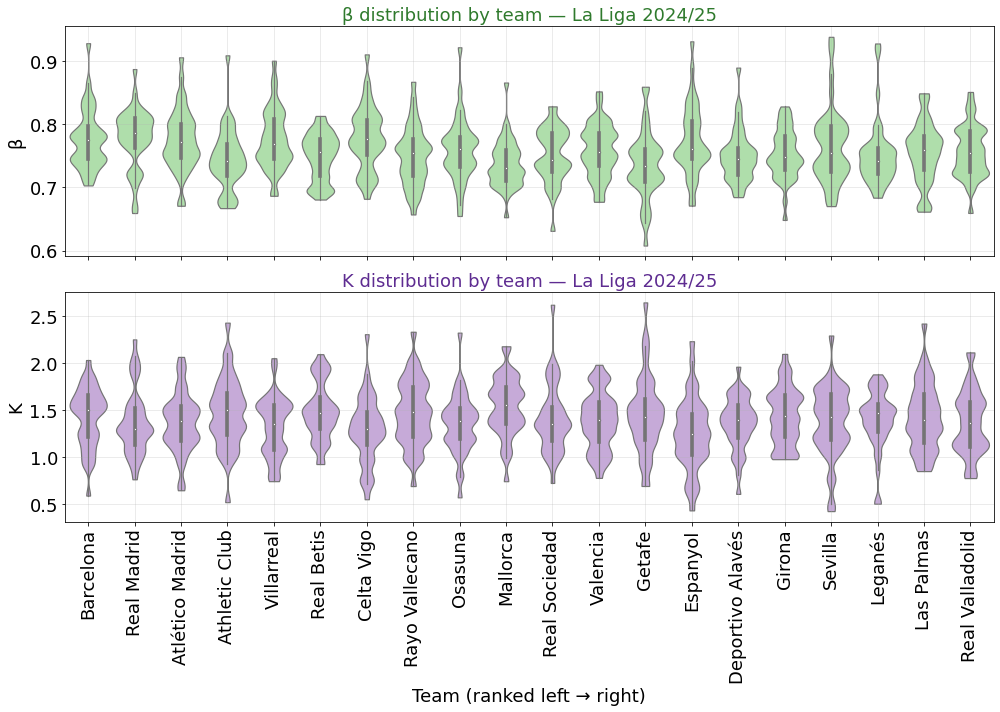

In [18]:
# --- Final La Liga 2024/25 ranking (ordered left → right) ---
ranking = [
    "Barcelona",
    "Real Madrid",
    "Atlético Madrid",
    "Athletic Club",
    "Villarreal",
    "Real Betis",
    "Celta Vigo",
    "Rayo Vallecano",
    "Osasuna",
    "Mallorca",
    "Real Sociedad",
    "Valencia",
    "Getafe",
    "Espanyol",
    "Deportivo Alavés",
    "Girona",
    "Sevilla",
    "Leganés",
    "Las Palmas",
    "Real Valladolid",
]

# --- Clean names ---
df = heaps_df_La_Liga_24_25.copy()
df["team_name"] = (
    df["team_name"].astype(str)
    .str.replace(r"[\u200b-\u200d\uFEFF]", "", regex=True)
    .str.replace(r"\xa0", " ", regex=False)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# --- Filter valid data ---
df = df[df["team_name"].isin(ranking)].copy()
df_beta = df[np.isfinite(df["beta"])].dropna(subset=["beta"]).copy()
df_K = df[np.isfinite(df["K"])].dropna(subset=["K"]).copy()

for d in (df_beta, df_K):
    d["team_name"] = pd.Categorical(d["team_name"], categories=ranking, ordered=True)

# --- Colors ---
green_fill, green_edge = "#A8E6A3", "#2F7A2D"   # light + dark green
violet_fill, violet_edge = "#C8A2E0", "#5E2C91" # light + dark violet

# --- Plot (2×1 layout) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- β distribution (green violin) ---
sns.violinplot(
    data=df_beta, x="team_name", y="beta", order=ranking,
    ax=axes[0],
    inner="box",  # show median and quartiles
    linewidth=1.2,
    cut=0,
    bw=0.2,
    scale="width",
    color=green_fill,
)
axes[0].set_title("β distribution by team — La Liga 2024/25", fontsize=18, color=green_edge)
axes[0].set_ylabel("β", fontsize=18)
axes[0].grid(True, alpha=0.3)

# 🔹 Remove x-labels on top plot
axes[0].set_xlabel("")
axes[0].set_xticklabels([])

# --- K distribution (violet violin) ---
sns.violinplot(
    data=df_K, x="team_name", y="K", order=ranking,
    ax=axes[1],
    inner="box",
    linewidth=1.2,
    cut=0,
    bw=0.2,
    scale="width",
    color=violet_fill,
)
axes[1].set_title("K distribution by team — La Liga 2024/25", fontsize=18, color=violet_edge)
axes[1].set_ylabel("K", fontsize=18)
axes[1].set_xlabel("Team (ranked left → right)", fontsize=18)
axes[1].grid(True, alpha=0.3)

# 🔹 Larger tick labels
axes[0].tick_params(axis="y", labelsize=18)
axes[1].tick_params(axis="x", labelsize=18, rotation=90)
axes[1].tick_params(axis="y", labelsize=18)

plt.tight_layout()
plt.show()

## Premier League

In [19]:
INPUT_DIR = "Premier_League_24_25_texts"

In [20]:
teams = set()

for csv_path in glob(os.path.join(INPUT_DIR, "*.csv")):
    try:
        df = pd.read_csv(csv_path, usecols=["team_name"])
        teams.update(df["team_name"].dropna().unique())
    except Exception as e:
        print(f"⚠️  Error reading {os.path.basename(csv_path)}: {e}")

unique_teams = sorted(teams)
print(f"✅ Found {len(unique_teams)} unique teams:\n")
for t in unique_teams:
    print("-", t)

✅ Found 20 unique teams:

- AFC Bournemouth
- Arsenal
- Aston Villa
- Brentford
- Brighton & Hove Albion
- Chelsea
- Crystal Palace
- Everton
- Fulham
- Ipswich Town
- Leicester City
- Liverpool
- Manchester City
- Manchester United
- Newcastle United
- Nottingham Forest
- Southampton
- Tottenham Hotspur
- West Ham United
- Wolverhampton Wanderers


In [21]:
# === Loop su tutti i CSV ===
results = []
csv_files = glob(os.path.join(INPUT_DIR, "*.csv"))

for csv_path in tqdm(csv_files, desc="🔹 Calcolo Heaps' Law per ogni match", ncols=100):
    try:
        df = pd.read_csv(csv_path)
        if df.empty or "words" not in df.columns:
            continue

        team = df.iloc[0]["team_name"]
        match_id = df.iloc[0]["match_id"]

        K, beta = compute_heaps_params(df)
        if K is not None and beta is not None:
            results.append({
                "team_name": team,
                "match_id": match_id,
                "K": K,
                "beta": beta
            })
    except Exception as e:
        tqdm.write(f"❌ Errore su {os.path.basename(csv_path)}: {e}")

🔹 Calcolo Heaps' Law per ogni match: 100%|██████████████████████| 760/760 [00:06<00:00, 115.27it/s]


In [22]:
heaps_df_Premier_League_24_25 = pd.DataFrame(results)
heaps_df_Premier_League_24_25.head()

,team_name,match_id,K,beta
0,AFC Bournemouth,3955632,0.870315,0.820782
1,AFC Bournemouth,3955649,1.252042,0.768616
2,AFC Bournemouth,3955653,1.364737,0.752472
3,AFC Bournemouth,3955661,1.274865,0.740062
4,AFC Bournemouth,3955671,1.036197,0.786943


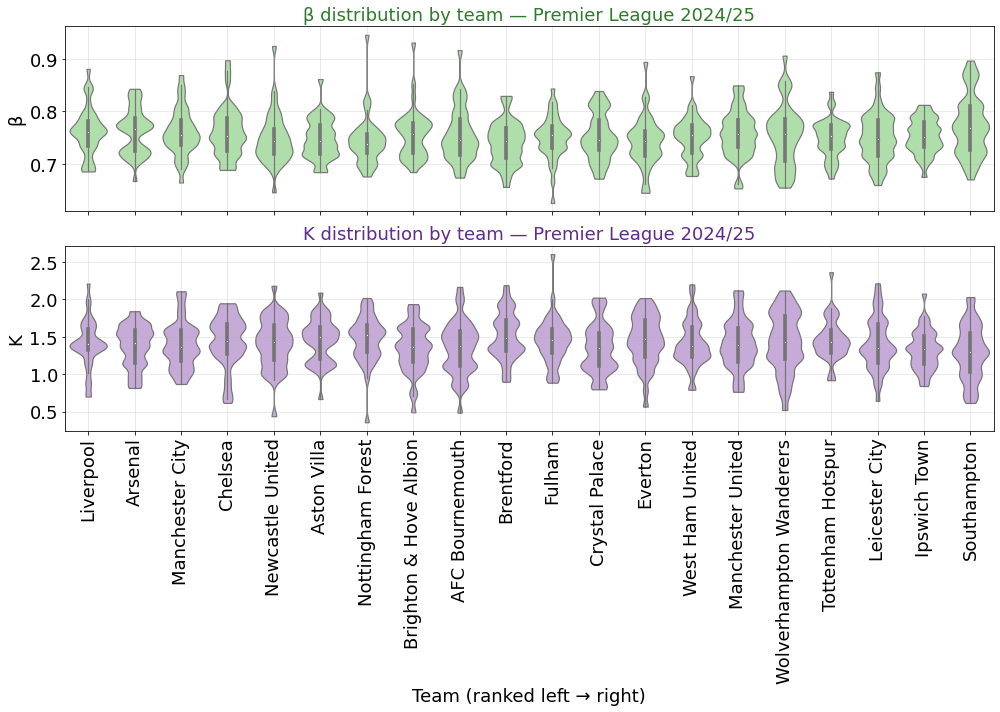

In [23]:
ranking = [
    "Liverpool",
    "Arsenal",
    "Manchester City",
    "Chelsea",
    "Newcastle United",
    "Aston Villa",
    "Nottingham Forest",
    "Brighton & Hove Albion",
    "AFC Bournemouth",
    "Brentford",
    "Fulham",
    "Crystal Palace",
    "Everton",
    "West Ham United",
    "Manchester United",
    "Wolverhampton Wanderers",
    "Tottenham Hotspur",
    "Leicester City",
    "Ipswich Town",
    "Southampton",
]

# --- Clean names ---
df = heaps_df_Premier_League_24_25.copy()
df["team_name"] = (
    df["team_name"].astype(str)
    .str.replace(r"[\u200b-\u200d\uFEFF]", "", regex=True)
    .str.replace(r"\xa0", " ", regex=False)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# --- Filter valid data ---
df = df[df["team_name"].isin(ranking)].copy()
df_beta = df[np.isfinite(df["beta"])].dropna(subset=["beta"]).copy()
df_K = df[np.isfinite(df["K"])].dropna(subset=["K"]).copy()

for d in (df_beta, df_K):
    d["team_name"] = pd.Categorical(d["team_name"], categories=ranking, ordered=True)

# --- Colors ---
green_fill, green_edge = "#A8E6A3", "#2F7A2D"   # light + dark green
violet_fill, violet_edge = "#C8A2E0", "#5E2C91" # light + dark violet

# --- Plot (2×1 layout) ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- β distribution (green violin) ---
sns.violinplot(
    data=df_beta, x="team_name", y="beta", order=ranking,
    ax=axes[0],
    inner="box",
    linewidth=1.2,
    cut=0,
    bw=0.2,
    scale="width",
    color=green_fill,
)
axes[0].set_title("β distribution by team — Premier League 2024/25", fontsize=18, color=green_edge)
axes[0].set_ylabel("β", fontsize=18)
axes[0].grid(True, alpha=0.3)

# 🔹 Remove x-labels on top plot
axes[0].set_xlabel("")
axes[0].set_xticklabels([])

# --- K distribution (violet violin) ---
sns.violinplot(
    data=df_K, x="team_name", y="K", order=ranking,
    ax=axes[1],
    inner="box",
    linewidth=1.2,
    cut=0,
    bw=0.2,
    scale="width",
    color=violet_fill,
)
axes[1].set_title("K distribution by team — Premier League 2024/25", fontsize=18, color=violet_edge)
axes[1].set_ylabel("K", fontsize=18)
axes[1].set_xlabel("Team (ranked left → right)", fontsize=18)
axes[1].grid(True, alpha=0.3)

# 🔹 Larger tick labels
axes[0].tick_params(axis="y", labelsize=18)
axes[1].tick_params(axis="x", labelsize=18, rotation=90)
axes[1].tick_params(axis="y", labelsize=18)

plt.tight_layout()
plt.show()

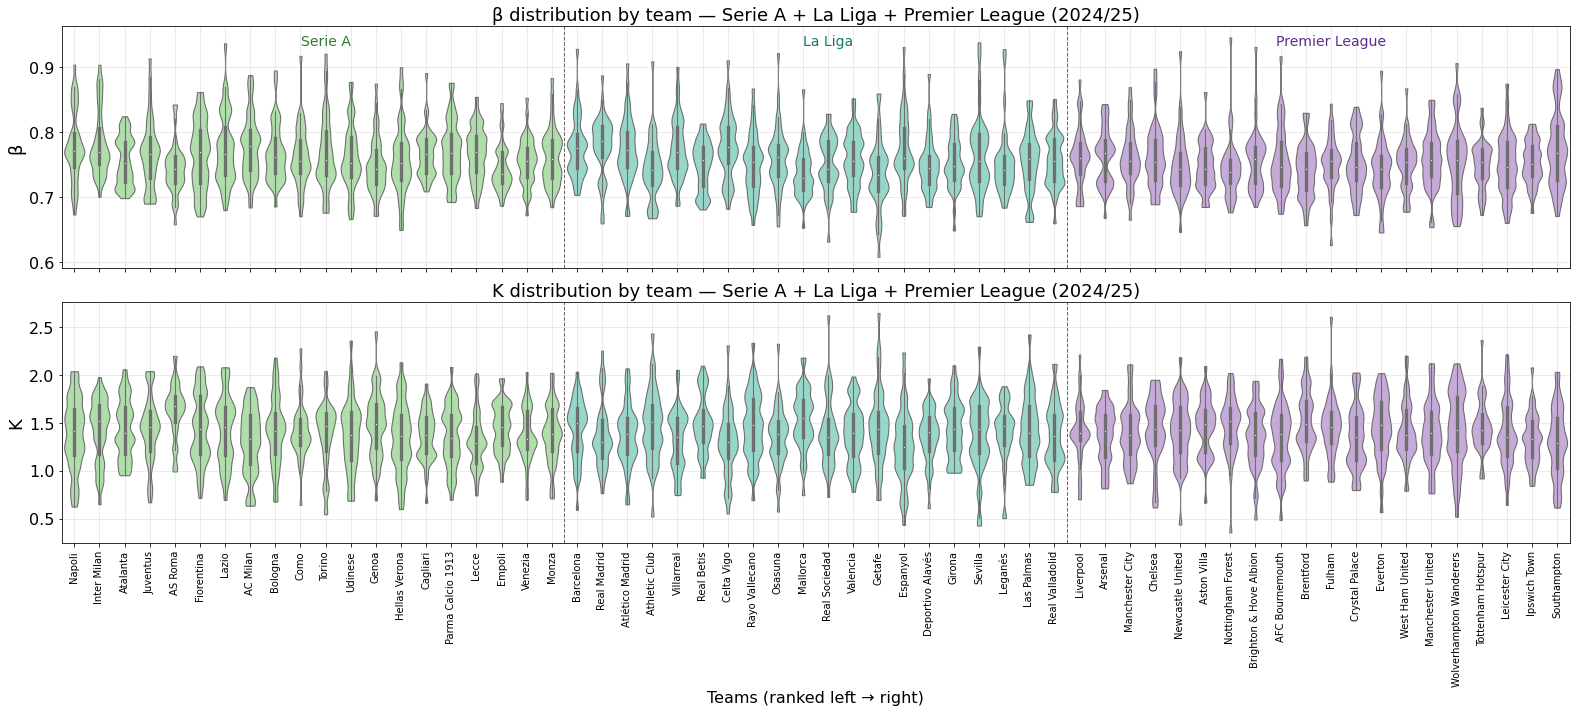

In [31]:
# --- Rankings ---
ranking_serie_a = [
    "Napoli", "Inter Milan", "Atalanta", "Juventus", "AS Roma", "Fiorentina", "Lazio",
    "AC Milan", "Bologna", "Como", "Torino", "Udinese", "Genoa", "Hellas Verona",
    "Cagliari", "Parma Calcio 1913", "Lecce", "Empoli", "Venezia", "Monza",
]

ranking_la_liga = [
    "Barcelona", "Real Madrid", "Atlético Madrid", "Athletic Club", "Villarreal",
    "Real Betis", "Celta Vigo", "Rayo Vallecano", "Osasuna", "Mallorca",
    "Real Sociedad", "Valencia", "Getafe", "Espanyol", "Deportivo Alavés",
    "Girona", "Sevilla", "Leganés", "Las Palmas", "Real Valladolid",
]

ranking_premier = [
    "Liverpool", "Arsenal", "Manchester City", "Chelsea", "Newcastle United",
    "Aston Villa", "Nottingham Forest", "Brighton & Hove Albion", "AFC Bournemouth",
    "Brentford", "Fulham", "Crystal Palace", "Everton", "West Ham United",
    "Manchester United", "Wolverhampton Wanderers", "Tottenham Hotspur",
    "Leicester City", "Ipswich Town", "Southampton",
]

# --- Clean function ---
def _clean(df):
    return (
        df.copy()
        .assign(
            team_name=lambda d: d["team_name"]
            .astype(str)
            .str.replace(r"[\u200b-\u200d\uFEFF]", "", regex=True)
            .str.replace(r"\xa0", " ", regex=False)
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
        )
    )

# --- Load and clean ---
dfA = _clean(heaps_df_Serie_A_24_25).assign(League="Serie A")
dfL = _clean(heaps_df_La_Liga_24_25).assign(League="La Liga")
dfP = _clean(heaps_df_Premier_League_24_25).assign(League="Premier League")

# --- Filter valid teams ---
dfA = dfA[dfA["team_name"].isin(ranking_serie_a)].copy()
dfL = dfL[dfL["team_name"].isin(ranking_la_liga)].copy()
dfP = dfP[dfP["team_name"].isin(ranking_premier)].copy()

# --- Combine all ---
ordered_all = ranking_serie_a + ranking_la_liga + ranking_premier
df_all = pd.concat([dfA, dfL, dfP], ignore_index=True)

# --- Filter valid β and K ---
df_beta = df_all[np.isfinite(df_all["beta"])].dropna(subset=["beta"]).copy()
df_K = df_all[np.isfinite(df_all["K"])].dropna(subset=["K"]).copy()

# --- Ordered categories ---
df_beta["team_name"] = pd.Categorical(df_beta["team_name"], categories=ordered_all, ordered=True)
df_K["team_name"] = pd.Categorical(df_K["team_name"], categories=ordered_all, ordered=True)

# --- League color map (different shades) ---
league_colors = {
    "Serie A": ("#A8E6A3", "#2F7A2D"),       # light green
    "La Liga": ("#8EE0D0", "#16796D"),       # teal
    "Premier League": ("#C8A2E0", "#5E2C91"),# violet
}

# --- Prepare color list for each team in global order ---
team_to_color = {}
for team in ranking_serie_a:
    team_to_color[team] = league_colors["Serie A"][0]
for team in ranking_la_liga:
    team_to_color[team] = league_colors["La Liga"][0]
for team in ranking_premier:
    team_to_color[team] = league_colors["Premier League"][0]

palette = [team_to_color[t] for t in ordered_all]

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)

# --- β violin ---
sns.violinplot(
    data=df_beta, x="team_name", y="beta", order=ordered_all,
    ax=axes[0], inner="box", linewidth=1.1, cut=0, bw=0.2, scale="width",
    palette=palette,
)
axes[0].set_title("β distribution by team — Serie A + La Liga + Premier League (2024/25)", fontsize=18)
axes[0].set_ylabel("β", fontsize=18)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel("")
axes[0].set_xticklabels([])

# --- K violin ---
sns.violinplot(
    data=df_K, x="team_name", y="K", order=ordered_all,
    ax=axes[1], inner="box", linewidth=1.1, cut=0, bw=0.2, scale="width",
    palette=palette,
)
axes[1].set_title("K distribution by team — Serie A + La Liga + Premier League (2024/25)", fontsize=18)
axes[1].set_ylabel("K", fontsize=18)
axes[1].set_xlabel("Teams (ranked left → right)", fontsize=16)
axes[1].grid(True, alpha=0.3)

# --- Axis style ---
axes[0].tick_params(axis="y", labelsize=16)
axes[1].tick_params(axis="x", labelsize=10, rotation=90)
axes[1].tick_params(axis="y", labelsize=16)

# --- Vertical separators and league labels (only top plot) ---
for ax in axes:
    ax.axvline(x=19.5, color="#666", linestyle="--", linewidth=1)
    ax.axvline(x=39.5, color="#666", linestyle="--", linewidth=1)

# ✅ Labels only on top plot
axes[0].text(10,  axes[0].get_ylim()[1]*0.97, "Serie A", ha="center", fontsize=14, color=league_colors["Serie A"][1])
axes[0].text(30,  axes[0].get_ylim()[1]*0.97, "La Liga", ha="center", fontsize=14, color=league_colors["La Liga"][1])
axes[0].text(50,  axes[0].get_ylim()[1]*0.97, "Premier League", ha="center", fontsize=14, color=league_colors["Premier League"][1])

plt.tight_layout()
plt.show()

## Win vs Lose

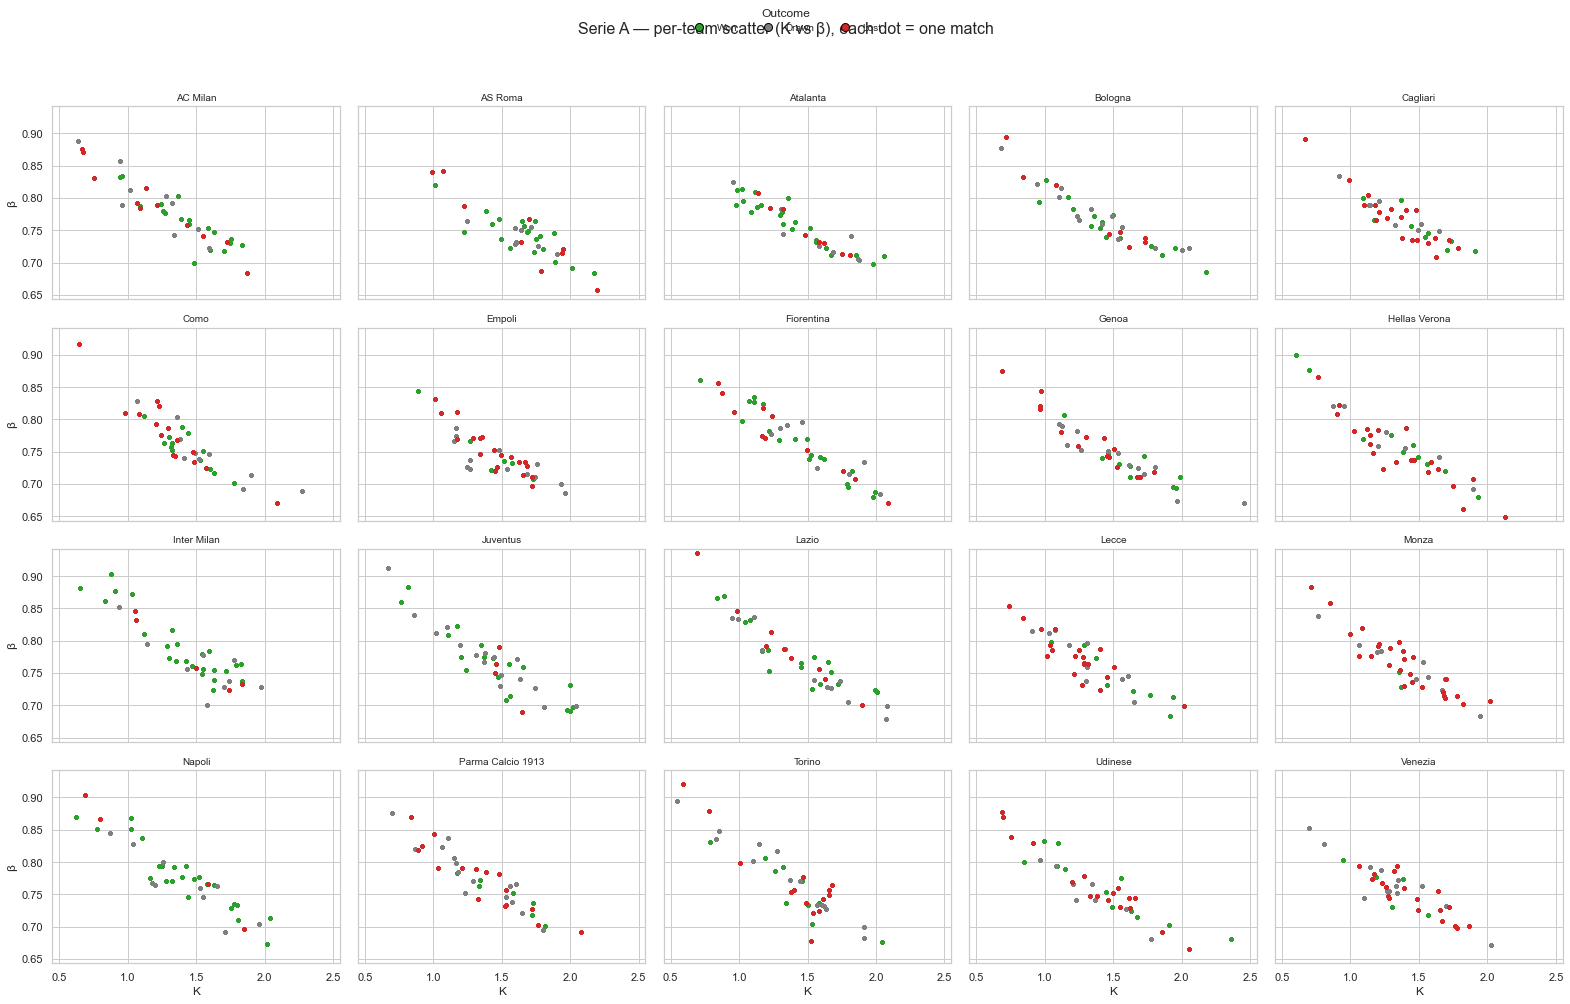

In [41]:
# ==== Load all Serie A CSVs (NO glob) ====
DIR = "Serie_A_24_25_texts"  # folder with your Serie A CSVs
csv_paths = [os.path.join(DIR, f) for f in os.listdir(DIR) if f.endswith(".csv")]
df = pd.concat([pd.read_csv(p) for p in csv_paths], ignore_index=True)

# ---- Normalize columns ----
df["outcome"] = (
    df["outcome"].astype(str).str.strip().str.capitalize()
      .replace({"Draw": "Drawn", "Win": "Won", "Lose": "Lost"})
)
df["K"] = pd.to_numeric(df["K"], errors="coerce")
df["beta"] = pd.to_numeric(df["beta"], errors="coerce")
df = df.dropna(subset=["team_name", "K", "beta", "outcome"])

# ---- Color mapping & hue order ----
colors = {"Won": "#2ca02c", "Lost": "#d62728", "Drawn": "#7f7f7f"}
hue_order = ["Won", "Drawn", "Lost"]

# ---- Teams order (alphabetical; change if you prefer ranking by K) ----
teams = sorted(df["team_name"].unique())

# ---- Common axis limits across all teams (so panels are comparable) ----
xmin, xmax = df["K"].min(), df["K"].max()
ymin, ymax = df["beta"].min(), df["beta"].max()
xpad = 0.05 * (xmax - xmin) if xmax > xmin else 0.1
ypad = 0.02 * (ymax - ymin) if ymax > ymin else 0.02
xlim = (xmin - xpad, xmax + xpad)
ylim = (ymin - ypad, ymax + ypad)

# ==== Figure: 4 rows × 5 cols ====
fig, axes = plt.subplots(4, 5, figsize=(22, 14), sharex=True, sharey=True)
axes = axes.flatten()

for i, team in enumerate(teams[:20]):  # ensure max 20 slots
    ax = axes[i]
    sub = df[df["team_name"] == team]

    # plot one color at a time (keeps legend tidy)
    for outcome in hue_order:
        part = sub[sub["outcome"] == outcome]
        if not part.empty:
            ax.scatter(
                part["K"], part["beta"],
                s=18, alpha=0.85, linewidths=0, color=colors[outcome]
            )

    ax.set_title(team, fontsize=10)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

# Hide unused panels if fewer than 20 teams
for j in range(len(teams), 20):
    axes[j].axis("off")

# Axis labels on outer edges only (to reduce clutter)
for r in range(4):
    axes[r * 5].set_ylabel("β")
for c in range(5):
    axes[(4 * 5 - 5) + c].set_xlabel("K")

# One consolidated legend
legend_elems = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=colors["Won"], markersize=8, label="Won"),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=colors["Drawn"], markersize=8, label="Drawn"),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=colors["Lost"], markersize=8, label="Lost"),
]
fig.legend(handles=legend_elems, title="Outcome", loc="upper center", ncol=3, frameon=False, fontsize=10)

fig.suptitle("Serie A — per-team scatter (K vs β), each dot = one match", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [45]:
DIR = "Serie_A_24_25_texts"

# === 1️⃣ Load all matches (1 CSV per match) ===
csv_paths = [os.path.join(DIR, f) for f in os.listdir(DIR) if f.endswith(".csv")]

records = []
for path in csv_paths:
    df = pd.read_csv(path)
    df["outcome"] = df["outcome"].astype(str).str.strip().str.capitalize().replace(
        {"Draw": "Drawn", "Win": "Won", "Lose": "Lost"}
    )
    df["K"] = pd.to_numeric(df["K"], errors="coerce")
    df["beta"] = pd.to_numeric(df["beta"], errors="coerce")

    # take one row per team (since K,beta identical)
    df_team = df.groupby("team_name", as_index=False).first()[["team_name", "outcome", "K", "beta"]]
    df_team["match_file"] = os.path.basename(path)
    records.append(df_team)

all_matches = pd.concat(records, ignore_index=True)

# === 2️⃣ Check match count per team ===
counts = all_matches["team_name"].value_counts()
print("\n[Info] Match count per team:")
print(counts.sort_index().to_string())

# === 3️⃣ KS tests (Won vs Lost) for each team ===
results = []
for team, g in all_matches.groupby("team_name"):
    won = g[g["outcome"] == "Won"]
    lost = g[g["outcome"] == "Lost"]
    n_won, n_lost = len(won), len(lost)

    if n_won < 3 or n_lost < 3:
        results.append({
            "team": team, "n_won": n_won, "n_lost": n_lost,
            "KS_stat_K": np.nan, "p_value_K": np.nan,
            "KS_stat_beta": np.nan, "p_value_beta": np.nan,
            "note": "insufficient data"
        })
        continue

    # Kolmogorov–Smirnov two-sample test
    ks_K = stats.ks_2samp(won["K"], lost["K"], alternative="two-sided")
    ks_B = stats.ks_2samp(won["beta"], lost["beta"], alternative="two-sided")

    results.append({
        "team": team,
        "n_won": n_won, "n_lost": n_lost,
        "KS_stat_K": ks_K.statistic, "p_value_K": ks_K.pvalue,
        "KS_stat_beta": ks_B.statistic, "p_value_beta": ks_B.pvalue,
        "note": ""
    })

# === 4️⃣ Results table ===
res_df = pd.DataFrame(results).sort_values(["p_value_K", "p_value_beta"])
res_df


[Info] Match count per team:
team_name
AC Milan             38
AS Roma              38
Atalanta             38
Bologna              38
Cagliari             38
Como                 38
Empoli               38
Fiorentina           38
Genoa                38
Hellas Verona        38
Inter Milan          38
Juventus             38
Lazio                38
Lecce                38
Monza                38
Napoli               38
Parma Calcio 1913    38
Torino               38
Udinese              38
Venezia              38


,team,n_won,n_lost,KS_stat_K,p_value_K,KS_stat_beta,p_value_beta,note
13,Lecce,8,20,0.575000,0.030373,0.475000,0.115554,
0,AC Milan,18,11,0.469697,0.066098,0.358586,0.265166,
8,Genoa,10,15,0.500000,0.077405,0.500000,0.077405,
5,Como,13,15,0.389744,0.183198,0.333333,0.321181,
11,Juventus,18,4,0.500000,0.305947,0.277778,0.914559,
16,Parma Calcio 1913,7,16,0.383929,0.358746,0.500000,0.126209,
4,Cagliari,9,20,0.305556,0.489604,0.327778,0.429719,
2,Atalanta,22,8,0.318182,0.510071,0.306818,0.539865,
15,Napoli,24,4,0.416667,0.522295,0.416667,0.522295,
19,Venezia,5,19,0.368421,0.560041,0.389474,0.464333,
